# AdPMCMC

## Importing relevant packages and homemade functions

In [1]:
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import os
import time
import scipy
from scipy.stats import invgamma
from scipy.stats import norm
from scipy.stats import gamma

import matplotlib.pyplot as plt
import seaborn as sns
%pylab inline
%reload_ext line_profiler

from tqdm import tqdm 

# Homemade functions
from utils import process_date, stratified_resampling, gaussian_kernel_density, equation
from trajectorySimulation import trajectory_simulation
from SMC import SMC
from AdPMCMC import AdPMCMC_M0, AdPMCMC_M1, AdPMCMC_M2, AdPMCMC_M3, AdPMCMC_M4, AdPMCMC

Populating the interactive namespace from numpy and matplotlib


## Describing growth population models used

The generic observation equation we consider is

\begin{equation}
y_t = g_t (n_t) + w_t
\end{equation}

The observation model acknowledges that we typically do not observe the entire population of interest, but rather a sample realization and that the observation mechanisms we use are imperfect. We will assume $w_t \sim \mathcal{N}(0,\sigma_{w})$ and $g_t = Id$ since no further details are given in the article.


\begin{equation}
\tag{$M_{0}$}
\log N_{t+1} = \log N_t + b_0 + \epsilon_t
\end{equation}

\begin{equation}
\tag{$M_{1}$}
\log N_{t+1} = \log N_t + b_0 + b_1 N_t + \epsilon_t
\end{equation}

\begin{equation}
\tag{$M_{2}$}
\log N_{t+1} = \log N_t + b_0 + b_2 N_t^{b_3} + \epsilon_t
\end{equation}

\begin{equation}
\tag{$M_{3}$}
\log N_{t+1} = 2 \log N_t - \log(b_4 + N_t) + b_0 + b_1 N_t + \epsilon_t
\end{equation}

\begin{equation}
\tag{$M_{4}$}
\log N_{t+1} = \log N_t + b_5 + b_6 N_t + b_7 N_t^2 + \epsilon_t
\end{equation}

with $\epsilon_t \sim \mathcal{N}(0, \sigma_\epsilon^2)$. 

We put a Gaussian prior on the maximum per-individual growth rate parameter : $b_{0,1,2,3,5,6,7} \sim \mathcal{N}(0, 1)$ and Gamma prior on $b_4 \sim \mathcal{G}(1,10)$. 

We use inverse Gamma priors for the variance noises :
<h6 align="center">
$\sigma_\epsilon^2 \sim \mathcal{IG}(\alpha_\epsilon, \beta_\epsilon)$ and $\sigma_w^2 \sim \mathcal{IG}(\alpha_w, \beta_w)$
</h6>
with hyperpameters $\alpha_\epsilon=\alpha_w=\frac{T}{2}$ and $\beta_\epsilon=\beta_w=\frac{2(\alpha_\epsilon-1)}{10}$.

## MCMC kernel for $\theta$

We use an adaptive and non-adaptive kernel for theta proposal in the SMC sampler. See kernels.py for details

In [2]:
from kernels import non_adaptive_theta_proposal, adaptive_theta_proposal

## SMC sampler for $n_{1:T}$

We first simulate trajectory according to the growth models. Model used to plot trajectory can be changed by user

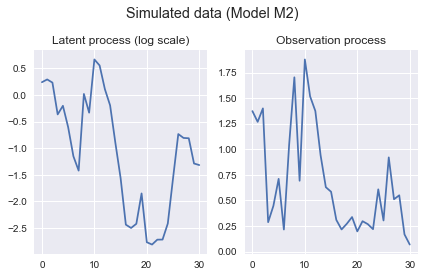

In [4]:
# Model choice and general model parameters
model = 'M2'
b_0 = 0.15
b_2 = -0.125
b_3 = 0.1
sigma_w = 0.39 # observation noise
sigma_eps = 0.47 # process noise
n_0 = 1.27 # starting point of latent variable
T = 30 # time horizon
L = 200 # number of particles

# Simulate and plot a trajectory
log_N, Y = trajectory_simulation(model = model, T=T, n_0=n_0, b_0=b_0, b_2=b_2, b_3=b_3,
                                sigma_eps=sigma_eps, sigma_w=sigma_w)

f, (ax1, ax2) = plt.subplots(1, 2)
st = f.suptitle("Simulated data (Model {})".format(model), fontsize="x-large")

ax1.plot(log_N)
ax1.set_title('Latent process (log scale)')
ax2.plot(Y)
ax2.set_title('Observation process')

plt.tight_layout()

st.set_y(0.95)
f.subplots_adjust(top=0.80)

Implementation of SMC sampler for $n_{1:T}$ (Algorithm 1 in Appendix of the article). SMC algorithm is in SMC.py script

-17.8354911159


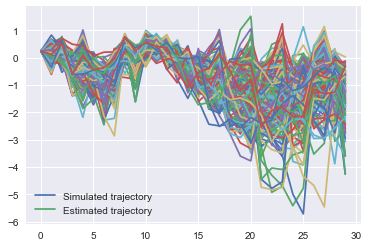

In [5]:
log_particles, log_W, log_marginal_likelihood = SMC(Y, T, L, n_0,model,sigma_eps, sigma_w,B_0=b_0,B_2=b_2,B_3=b_3)
#%lprun -f SMC SMC(Y, T, L, n_0,model,sigma_eps, sigma_w,B_0=b_0,B_2=b_2,B_3=b_3)
log_particles_averaged = [np.average(log_particles[t, :], weights=np.exp(log_W[t, :]), axis=0) 
                          for t in range(T)]

plt.plot(log_N[:-1])
plt.plot(log_particles) 
plt.legend(["Simulated trajectory", "Estimated trajectory"])
print(log_marginal_likelihood)

We check variance of log-likelihood on a few iterations of SMC :

In [6]:
vect_likelihood = []
iterations = 100
for i in range(iterations):
    log_particles, log_W, log_marginal_likelihood = SMC(Y, T, L, n_0,model,sigma_eps, sigma_w,B_0=b_0,B_2=b_2,B_3=b_3)
    vect_likelihood.append(log_marginal_likelihood)
print('Mean log-likelihood :' + str(np.mean(vect_likelihood))+' ; Variance : '+str(np.var(vect_likelihood)))

Mean log-likelihood :-17.9590539907 ; Variance : 0.100729978812


##  Applying PMCMC to synthetic data

We now apply adPMCMC algorithm to synthetic data simulated r.t. population growth models. Algorithm can be found in AdPMCMC.py script. 

User has to choose number of iterations of Monte Carlo (n_steps), number of particles (L) and adaptive rate.

In [7]:
model ='M2'
n_steps = 10000 # Number of iterations 
L = 150 # Number of particles
adaptive_rate = 0.5  # Adaptive rate (set to 0 for non-adaptive proposal)

In [ ]:
theta_hist = AdPMCMC(model,n_steps, T, adaptive_rate, Y, L, n_0)

In [ ]:
# 1373 samples accepted over 10k iterations
# burn-in time
theta_history = np.array(theta_hist[1000:])

In [ ]:
# Two subplots, the axes array is 1-d
f, axarr = plt.subplots(6, sharex=True)
axarr[0].plot(theta_history[:, 0])
axarr[0].set_ylabel(r'$b_0$', rotation=0, labelpad=10)
axarr[1].plot(theta_history[:, 1])
axarr[1].set_ylabel(r'$b_2$', rotation=0, labelpad=10)
axarr[2].plot(theta_history[:, 2])
axarr[2].set_ylabel(r'$b_3$', rotation=0, labelpad=10)
axarr[3].plot(theta_history[:, 3])
axarr[3].set_ylabel(r'$\sigma_w$', rotation=0, labelpad=20)
axarr[4].plot(theta_history[:, 4])
axarr[4].set_ylabel(r'$\sigma_\epsilon$', rotation=0, labelpad=20)
axarr[5].plot(theta_history[:, 5])
axarr[5].set_ylabel(r'$n_0$', rotation=0, labelpad=30)
savefig('MCMC_test.png')

In [ ]:
df = pd.DataFrame({r'$b_0$':theta_history[:,0], r'$b_2$':theta_history[:,1],
                      r'$b_3$':theta_history[:,2], r'$\sigma_\epsilon$':theta_history[:,3],
                   r'$\sigma_w$':theta_history[:,4], r'$n_0$':theta_history[:,5]})

sns.pairplot(df, diag_kind="kde", markers="+")
savefig('scatterplot_test'.png')

## Applying PMCMC to real data

We load the nutria database and plot the trajcetory of the myocastor coypus population :

In [8]:
df = pd.read_csv('nutria_data.csv')
df['YearMonth'] = df['TimeOfSample'].apply(process_date)
df.head()

TaxonName  MainID  TimeOfSample  Population  Abundance  YearMonth
0  Myocastor coypus    9833       1970.01        0.55        550   719163.0
1  Myocastor coypus    9833       1970.02        0.55        550   719194.0
2  Myocastor coypus    9833       1970.03        0.60        600   719222.0
3  Myocastor coypus    9833       1970.04        0.55        550   719253.0
4  Myocastor coypus    9833       1970.05        0.50        500   719283.0

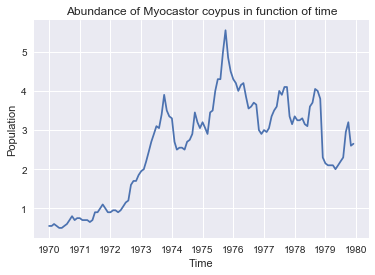

In [9]:
plt.plot_date(df["YearMonth"],df["Population"], '-')
plt.title('Abundance of Myocastor coypus in function of time')
plt.xlabel('Time')
plt.ylabel('Population')

-20.1723342843


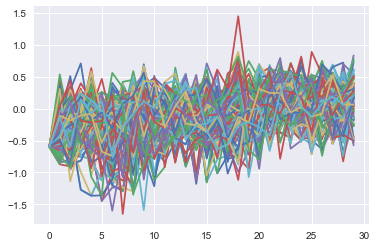

In [10]:
Y_nutria = df["Population"].tolist()
n_0_nutria = Y_nutria[0] 

T = 30
L = 150 
b_0 = 0.15
b_2 = 0.1
b_3 = 0.1
sigma_eps = 0.3
sigma_w = 0.47

log_particles, log_W, log_marginal_likelihood = SMC(Y_nutria, T, L, n_0_nutria, 
                                                    'M2', sigma_eps, sigma_w, B_0=b_0
                                                    , B_2=b_2, B_3=b_3)
log_particles_averaged = [np.average(log_particles[t, :], weights=np.exp(log_W[t, :]), axis=0) 
                          for t in range(T)]

plt.plot(log_particles)
print(log_marginal_likelihood)

In [11]:
vect_likelihood = []
iterations = 100
for i in range(iterations):
    log_particles, log_W, log_marginal_likelihood = SMC(Y_nutria, T, L, n_0_nutria,'M2',sigma_eps, sigma_w,B_0=b_0,B_2=b_2,B_3=b_3)
    vect_likelihood.append(log_marginal_likelihood)
print('Mean log-likelihood :' + str(np.mean(vect_likelihood))+' ; Variance : '+str(np.var(vect_likelihood)))

Mean log-likelihood :-20.7730056777 ; Variance : 0.197891354768


In [12]:
n_steps = 50000
L = 150
adaptive_rate = 0.5  # set to 0 -> non-adaptive proposal


#Résultats pour M0 : 31118 acceptés sur 100k itérations à 300 particules
#Résultats pour M1 : 12906 acceptés sur 50k itérations à 150 particules
#Résultats pour M2 : 13154 acceptés sur 50k itérations à 150 particules
#Résultats pour M4 : 14982 acceptés sur 50k itérations à 150 particules

#theta_hist_nutria_M0 = AdPMCMC('M0',n_steps, T, adaptive_rate, Y_nutria, L, n_0_nutria)
#theta_hist_nutria_M1 = AdPMCMC('M1',n_steps, T, adaptive_rate, Y_nutria, L, n_0_nutria)
theta_hist_nutria_M2 = AdPMCMC('M2',n_steps, T, adaptive_rate, Y_nutria, L, n_0_nutria)
#theta_hist_nutria_M3 = AdPMCMC('M3',n_steps, T, adaptive_rate, Y_nutria, L, n_0_nutria)
#theta_hist_nutria_M4 = AdPMCMC('M4',n_steps, T, adaptive_rate, Y_nutria, L, n_0_nutria)

Running AdPMCMC: 100%|██████████| 50000/50000 [1:21:32<00:00, 10.22it/s]


Number of samples : 13406


In [13]:
# burn-in time
#theta_history_nutria_M0 = np.array(theta_hist_nutria_M0[5000:])
#theta_history_nutria_M1 = np.array(theta_hist_nutria_M1[5000:])
theta_history_nutria_M2 = np.array(theta_hist_nutria_M2[5000:])
#theta_history_nutria_M3 = np.array(theta_hist_nutria_M3[5000:])
#theta_history_nutria_M4 = np.array(theta_hist_nutria_M4[5000:])

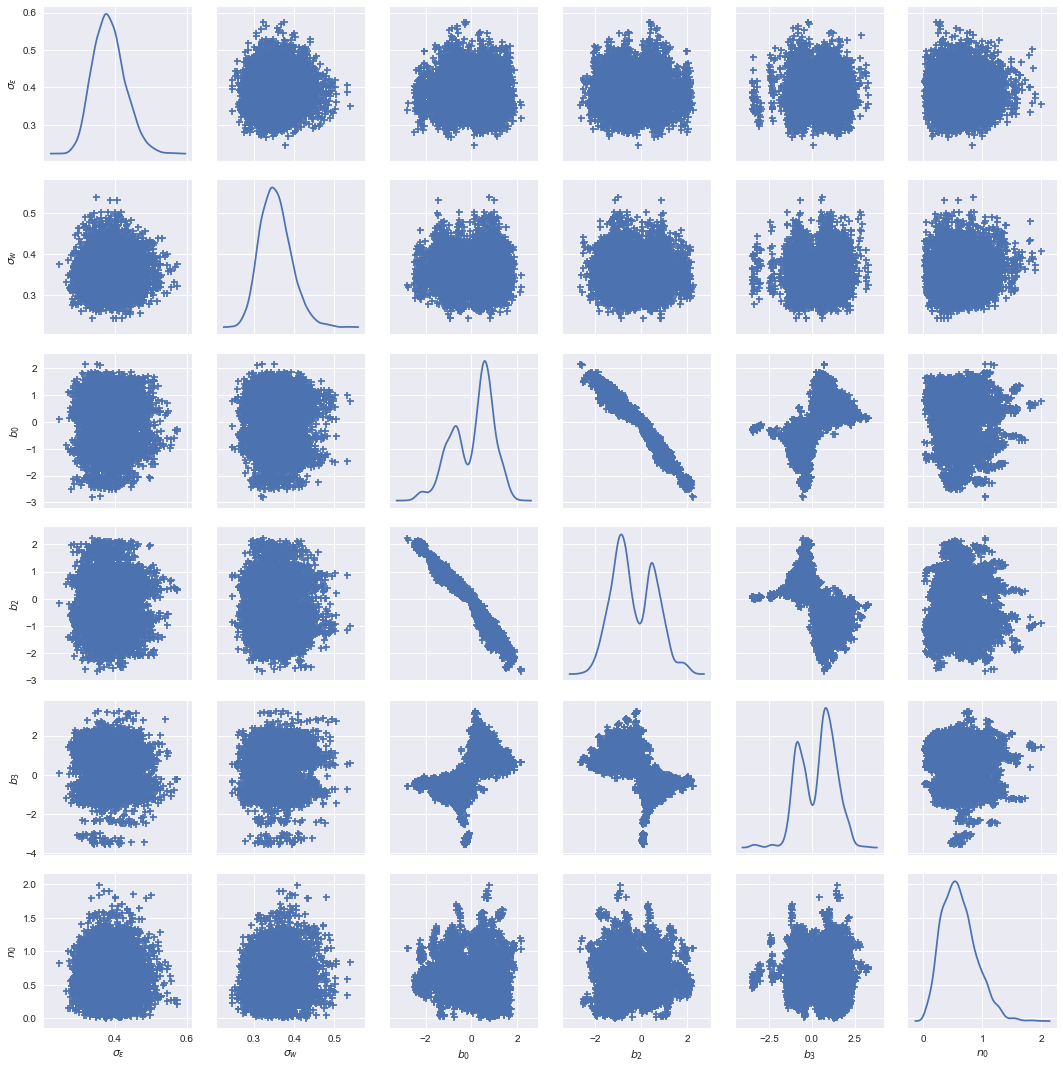

In [14]:
#df_M0_nutria = pd.DataFrame({r'$b_0$':theta_history_nutria_M0[:,0],r'$\sigma_\epsilon$':theta_history_nutria_M0[:,1],
#                   r'$\sigma_w$':theta_history_nutria_M0[:,2], r'$n_0$':theta_history_nutria_M0[:,3]})
#sns.pairplot(df_M0_nutria, diag_kind="kde", markers="+")
#savefig('scatterplot_nutria_M0.png')

#df_M1_nutria = pd.DataFrame({r'$b_0$':theta_history_nutria_M1[:,0],r'$b_1$':theta_history_nutria_M1[:,1]
#                            ,r'$\sigma_\epsilon$':theta_history_nutria_M1[:,2],
#                           r'$\sigma_w$':theta_history_nutria_M1[:,3], r'$n_0$':theta_history_nutria_M1[:,4],})
#sns.pairplot(df_M1_nutria, diag_kind="kde", markers="+")
#savefig('scatterplot_nutria_M1_burn_5000.png')

df_M2_nutria = pd.DataFrame({r'$b_0$':theta_history_nutria_M2[:,0], r'$b_2$':theta_history_nutria_M2[:,1],
                      r'$b_3$':theta_history_nutria_M2[:,2], r'$\sigma_\epsilon$':theta_history_nutria_M2[:,3],
                   r'$\sigma_w$':theta_history_nutria_M2[:,4], r'$n_0$':theta_history_nutria_M2[:,5]})
sns.pairplot(df_M2_nutria, diag_kind="kde", markers="+")
savefig('scatterplot_nutria_M2_burn_5000.png')

#df_M3_nutria = pd.DataFrame({r'$b_0$':theta_history_nutria_M3[:,0], r'$b_1$':theta_history_nutria_M3[:,1],
#                      r'$b_4$':theta_history_nutria_M3[:,2], r'$\sigma_\epsilon$':theta_history_nutria_M3[:,3],
#                   r'$\sigma_w$':theta_history_nutria_M3[:,4], r'$n_0$':theta_history_nutria_M3[:,5]})
#sns.pairplot(df_M3_nutria, diag_kind="kde", markers="+")
#savefig('scatterplot_nutria_M3.png')

#df_M4_nutria = pd.DataFrame({r'$b_5$':theta_history_nutria_M4[:,0], r'$b_6$':theta_history_nutria_M4[:,1],
#                      r'$b_7$':theta_history_nutria_M4[:,2], r'$\sigma_\epsilon$':theta_history_nutria_M4[:,3],
#                   r'$\sigma_w$':theta_history_nutria_M4[:,4], r'$n_0$':theta_history_nutria_M4[:,5]})
#sns.pairplot(df_M4_nutria, diag_kind="kde", markers="+")
#savefig('scatterplot_nutria_M4_burn_5000.png')

## Comparing differences between adaptive and non-adaptive proposals

We here compare the impact of taking an adaptive proposal for $\theta$ rather than a non-adaptive one. The adaptive proposal uses the previously drawn values of $\theta$ to update the covariance matrix of the gaussian used to draw new $\theta$.

In [15]:
n_steps = 5000
L = 100
rates = np.arange(0.0, 1.1, 0.1)
acceptance=[]
for r in rates:
    print(r'Running AdPMCMC for model M_0 and adaptive rate '+str(r))
    time.sleep(0.5)     
    accept = len(AdPMCMC('M2',n_steps, T,r, Y, L, n_0))/n_steps
    acceptance.append(accept)

Running AdPMCMC for model M_0 and adaptive rate 0.0


Running AdPMCMC: 100%|██████████| 5000/5000 [03:14<00:00, 25.66it/s]


Number of samples : 1644
Running AdPMCMC for model M_0 and adaptive rate 0.1


Running AdPMCMC: 100%|██████████| 5000/5000 [03:36<00:00, 23.13it/s]


Number of samples : 1996
Running AdPMCMC for model M_0 and adaptive rate 0.2


Running AdPMCMC: 100%|██████████| 5000/5000 [13:25<00:00,  6.21it/s]


Number of samples : 1999
Running AdPMCMC for model M_0 and adaptive rate 0.3


Running AdPMCMC: 100%|██████████| 5000/5000 [03:33<00:00, 23.39it/s]


Number of samples : 1731
Running AdPMCMC for model M_0 and adaptive rate 0.4


Running AdPMCMC: 100%|██████████| 5000/5000 [03:45<00:00, 22.13it/s]


Number of samples : 1701
Running AdPMCMC for model M_0 and adaptive rate 0.5


Running AdPMCMC: 100%|██████████| 5000/5000 [03:52<00:00, 21.50it/s]


Number of samples : 1621
Running AdPMCMC for model M_0 and adaptive rate 0.6


Running AdPMCMC: 100%|██████████| 5000/5000 [03:55<00:00, 21.19it/s]


Number of samples : 1399
Running AdPMCMC for model M_0 and adaptive rate 0.7


Running AdPMCMC: 100%|██████████| 5000/5000 [03:56<00:00, 21.18it/s]


Number of samples : 1220
Running AdPMCMC for model M_0 and adaptive rate 0.8


Running AdPMCMC: 100%|██████████| 5000/5000 [03:48<00:00, 21.91it/s]


Number of samples : 1223
Running AdPMCMC for model M_0 and adaptive rate 0.9


Running AdPMCMC: 100%|██████████| 5000/5000 [03:36<00:00, 23.11it/s]


Number of samples : 699
Running AdPMCMC for model M_0 and adaptive rate 1.0


Running AdPMCMC: 100%|██████████| 5000/5000 [32:06<00:00,  2.59it/s]

Number of samples : 788


[0.3288, 0.3992, 0.3998, 0.3462, 0.3402, 0.3242, 0.2798, 0.244, 0.2446, 0.1398, 0.1576]


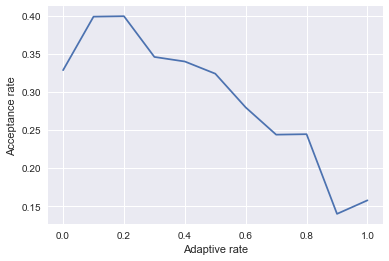

In [16]:
print(acceptance)
df_rate = pd.DataFrame(data={'Adaptive rate':rates,'Acceptance rate':acceptance})
plt.plot(df_rate["Adaptive rate"],df_rate["Acceptance rate"])
plt.xlabel('Adaptive rate')
plt.ylabel('Acceptance rate')
savefig('acceptance_rate.png')